# Hydrogeophysical modeling with [pyGIMLi](https://www.pygimli.org)
Coupled hydrogeophysical modeling example [presented at AGU17](https://zenodo.org/record/1095621) in a Jupyter Notebook.

### Imports and plot settings

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 3
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn
seaborn.set(context="notebook", style="white", font_scale=1.3)

## 1) Model creation

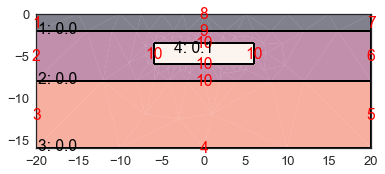

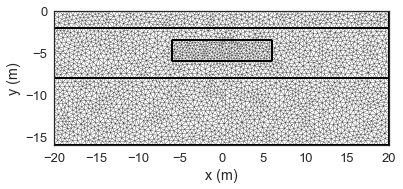

In [2]:
import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics.ert import ERTManager
import pygimli.physics.ert as ert
import pygimli.physics.petro as petro

# Create geometry definition for the modelling domain
world = mt.createWorld(start=[-20, 0], end=[20, -16], layers=[-2, -8],
                       worldMarker=False)

# Create a heterogeneous block
block = mt.createRectangle(start=[-6, -3.5], end=[6, -6.0],
                           marker=4,  boundaryMarker=10, area=0.1)

# Merge geometrical entities
geom = mt.mergePLC([world, block])
pg.show(geom, boundaryMarker=True)

# Create a mesh from the geometry definition
mesh = mt.createMesh(geom, quality=32, area=0.2, smooth=[1, 10])

fig, ax = plt.subplots()
pg.show(mesh, ax=ax, hold=True)
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")

## 2) Modeling groundwater flow

Fluid flow in a porous medium of slow non-viscous and non-frictional hydraulic movement is governed by Darcy's Law according to:

\begin{align}
K^{-1}\mathbf{v} + \nabla p & = 0 \\
\nabla \cdot \mathbf{v} & = 0\\
\text{leading}\,\,\text{to}\,\,
\nabla\cdot(K \nabla p) & = 0 \quad \text{on} \quad\Omega
\end{align}

We begin by defining isotropic values of hydraulic conductivity $K$ and mapping these to each mesh cell:

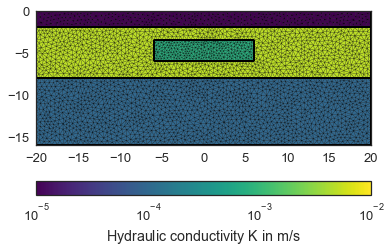

(<matplotlib.axes._subplots.AxesSubplot at 0x7fc4581edb00>, None)

In [3]:
# Map regions to hydraulic conductivity in $m/s$
kMap = [[1, 1e-8], [2, 5e-3], [3, 1e-4], [4, 8e-4]]

# Map conductivity value per region to each cell in the given mesh
K = pg.solver.parseMapToCellArray(kMap, mesh)

ax, _ = pg.show(mesh, data=K, label='Hydraulic conductivity $K$ in m$/$s',
                cMin=1e-5, cMax=1e-2, nLevs=4, cmap='viridis', hold=True)
pg.show(mesh, ax=ax)

The problem further boundary conditions of the hydraulic potential. We use $p=p_0=0.75$ m on the left and $p=0$ on the right boundary of the modelling domain, equaling a hydraulic gradient of 1.75%.

In [4]:
# Dirichlet conditions for hydraulic potential
pBound = [[[1, 2, 3], 0.75], [[5, 6, 7], 0.0]]

We can now call the finite element solver with the generated mesh, hydraulic conductivity and the boundary condition. The sought hydraulic velocity distribution can then be calculated as the
gradient field of $\mathbf{v}=-\nabla p$ and visualized using the generic `pg.show()` function.

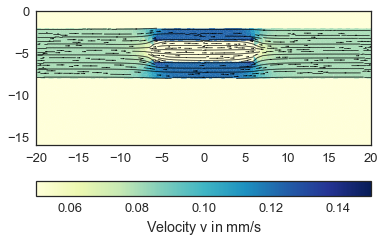

In [5]:
# Solve for hydraulic potential
p = pg.solver.solveFiniteElements(mesh, a=K, uB=pBound)

# Solve velocity as gradient of hydraulic potential
vel = -pg.solver.grad(mesh, p) * np.asarray([K, K, K]).T

ax, _ = pg.show(mesh, data=pg.abs(vel) * 1000, logScale=False, cMin=0.05, cMax=0.15,
                label='Velocity $v$ in mm$/$s', cmap='YlGnBu', hold=True)
ax, _ = pg.show(mesh, data=vel, ax=ax, color='k',  linewidth=0.8,
                dropTol=1e-5, hold=True)

## 3) Solving transport

In the next step, we use this velocity field to simulate the dynamic movement of a particle (e.g., salt) concentration $c(\mathbf{r}, t)$ in the aquifer by using the advection-diffusion equation

$$\frac{\partial c}{\partial t} = \underbrace{\nabla\cdot(D \nabla c)}_{\text{Diffusion / Dispersion}} - \underbrace{\nabla \cdot (\mathbf{v}\nabla c)}_{\text{Advection}} + S$$

In [6]:
S = pg.RVector(mesh.cellCount(), 0.0)
# Fill injection source vector for a fixed injection position
sourceCell = mesh.findCell([-19.1, -4.6])
S[sourceCell.id()] = 1.0 / sourceCell.size()  # g/(l s)

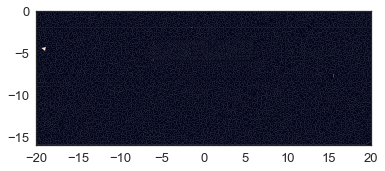

(<matplotlib.axes._subplots.AxesSubplot at 0x7fc438e8d470>, None)

In [7]:
pg.show(mesh, S)

We define a time vector and common velocity-depending dispersion coefficient $D = \alpha |\mathbf{v}|$ with a dispersivity $\alpha = 1\cdot10^{-2}$ m. We solve the advection-diffsuion equation on the equation level with the finite volume solver, which results in a particle concentration $c(\mathbf{r},t)$ (in g$/$l) for each cell center and time step.

In [8]:
# Choose 800 time steps for 6 days in seconds
t = pg.utils.grange(0, 6 * 24 * 3600, n=800)

# Create dispersitivity, depending on the absolute velocity
dispersion = pg.abs(vel) * 1e-2

# Solve for injection time, but we need velocities on cell nodes
veln = mt.cellDataToNodeData(mesh, vel)
c1 = pg.solver.solveFiniteVolume(mesh, a=dispersion, f=S, vel=veln,
                                 times=t, uB=[1, 0],
                                 scheme='PS', verbose=0)

# Solve without injection starting with last result
c2 = pg.solver.solveFiniteVolume(mesh, a=dispersion, f=0, vel=veln,
                                 u0=c1[-1], times=t, uB=[1, 0],
                                 scheme='PS', verbose=0)
# Stack results together
c = np.vstack((c1, c2))

We can now visualize the result:

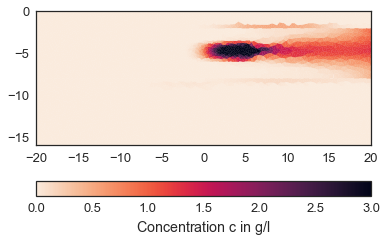

In [9]:
from IPython.display import clear_output

for ci in c[1:][::25]:
    pg.show(mesh, data=ci*0.001, cMin=0, cMax=3, cmap="rocket_r", label="Concentration c in $g/l$")
    clear_output(wait=True)

## 4) Simulate time-lapse electrical resistivity measurements

Create a dipole-dipole measurement scheme and a suitable mesh for ERT forward simulations.

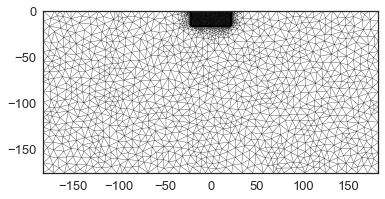

(<matplotlib.axes._subplots.AxesSubplot at 0x7fc41b820550>, None)

In [10]:
ertScheme = ert.createERTData(pg.utils.grange(-20, 20, dx=1.0),
                              schemeName='dd')

# Create suitable mesh for ert forward calculation
meshERT = mt.createParaMesh(ertScheme, quality=33, paraMaxCellSize=0.2,
                            boundaryMaxCellSize=50, smooth=[1, 2])
pg.show(meshERT)

Use simulated concentrations to calculate bulk resistivity using Archie's Law and fill matrix with apparent resistivity ratios with respect to a background model:

In [11]:
# Select 10 time frame to simulate ERT data
timesERT = pg.IndexArray(np.floor(np.linspace(0, len(c)-1, 10)))

# Create conductivity of fluid for salt concentration $c$
sigmaFluid = c[timesERT] * 0.1 + 0.01

# Calculate bulk resistivity based on Archie's Law
resBulk = petro.resistivityArchie(rFluid=1. / sigmaFluid,
                                  porosity=0.3, m=1.3,
                                  mesh=mesh, meshI=meshERT, fill=1)

# apply background resistivity model
rho0 = np.zeros(meshERT.cellCount()) + 1000.
for c in meshERT.cells():
    if c.center()[1] < -8:
        rho0[c.id()] = 150.
    elif c.center()[1] < -2:
        rho0[c.id()] = 500.
resis = pg.RMatrix(resBulk)
for i, rbI in enumerate(resBulk):
    resis[i] = 1. / ((1./rbI) + 1./rho0)

Initialize and call the ERT manager for electrical simulation:

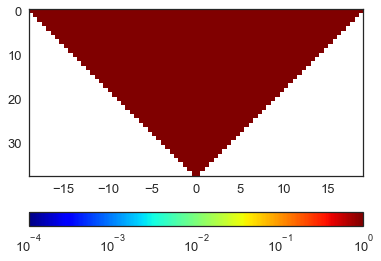

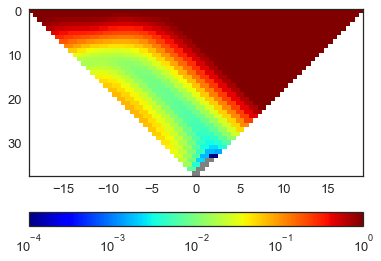

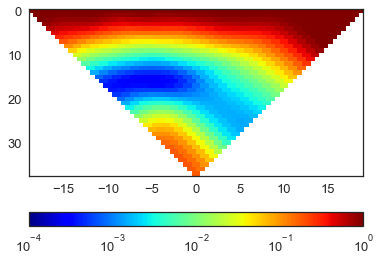

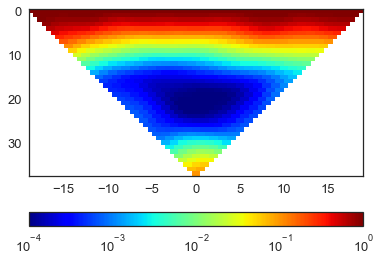

In [13]:
# Initialize ert method manager
ERT = ERTManager(verbose=False)
# Run  simulation for  the apparent resistivities
rhoa = ERT.simulate(meshERT, resis, ertScheme, verbose=0, returnArray=True)

for i in range(4):
    ERT.showData(ertScheme, vals=rhoa[i]/rhoa[0])

The inversion part would exceed the computational resources available for this live demo, but the corresponding Python script can be downloaded [here](http://cg17.pygimli.org). See [pygimli.org](https://www.pygimli.org) for more examples and tutorials.